# Understanding and Predicting Property Maintenance Fines in Detroit City

This project is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). It's the fourth assignment from the course 'Applied Machine Learning in Python' of University of Michigan, taken through coursera.

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. The project's goal is to predict whether a given blight ticket will be paid on time.

All data for this project has been provided to coursera through the [Detroit Open Data Portal](https://data.detroitmi.gov/). Only the data included in the coursera directory will be used for training the model for this project. We will use the data of [Detroit Blight-Violations Records](https://data.detroitmi.gov/Property-Parcels/Blight-Violations/ti6p-wcg4) to get the score of the classifier in the AUC_score.
___

The course provides you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. **The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible.** Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** 

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

The predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this project is the Area Under the ROC Curve (AUC). 

The performance of the classifier will be tested based on the AUC score computed for the classifier. The goal of this project is to get AUC_score > 0.7.
___

For this project, a function is created that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, it returns a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32


## Structure of the function

The structure of the function will be as follow:

PART I: Build the classifier and run it on the provided training data

1. Import all the needed packages.
2. read the needed files into a dataframe, then organize and fix the dataframes from small problems, i.e. mixed types value an etc. Afterward build the feature space and the label space.
3. Appraise the problem beforehand to decide whether it is an imbalanced classification problem or not.
4. Decide which classifier to use, organize the feature space and the label space appropriately and engage the classifier.
5. Plot the ROC for the y_test that was splitted from the training data train.csv file.

PART II: Run the classifier on the provided test file and calculate the 'AUC_score' 

1. Read the test file, organize the test file and merge it with the Blight_Violations file in order to get the label feature.
2. Engage the classifier on the feature space of the test.csv file.
3. Plot the ROC for the y_test that was gathered from the test.csv file.
4. returns a series of length 61001 with the data being the probability that each corresponding ticket from test.csv will be paid, and the index being the ticket_id.

## PART I: Build the classifier and run it on the provided training data

In [14]:
# 1. Import all the needed packeges.

# needed
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# from the sklearn.ensemble module, we import the GradientBoostingClassifier class for the clasifier in use
from sklearn.ensemble import GradientBoostingClassifier
# can't pass str to the model fit() method hence import preprocessing from sklearn
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

# in order to check the performance of the classifier import roc_curve, auc
from sklearn.metrics import roc_curve, auc

Next, I am going to handle the train.csv file. Some of the columns are redundant for the feature space and the label space, since they don't exist in the test.csv file, so they will be deleted.  Also, as mentioned, some of the columns have mixed type, which makes the reading of file longer and problematic, so I will use 'dtype' in the 'pd.read_csv' function.

In [15]:
# 2. read the needed files into a dataframe, then organize and fix the dataframes from small problems, 
# i.e. mixed types value an etc. Afterward build the feature space and the label space.

# read the training data of blight ticket compliance in Detroit into a dataframe 
df = pd.read_csv('train.csv', header=0, sep=',', encoding='cp1252',  
                 dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str, 'violator_name':str, 
                        'mailing_address_str_number': str}) 
# since: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
#  interactivity=interactivity, compiler=compiler, result=result)
# we have to specify the type, i.e  dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str}
# encoding='latin1', encoding='iso-8859-1' or encoding='cp1252'; encoding = utf-8 these the various encodings found on Windows.

# Select rows where ticket receiver is Responsible i.e. df.compliance = 0 or 1 since, 'Not responsible' doesn't exists in the test file
df = df[(df['compliance'] == 0.0) | (df['compliance'] == 1.0)]

# handeling the unwanted charachter: remove '>' in 'mailing_address_str_name'
df['mailing_address_str_name'] = df['mailing_address_str_name'].str.replace(r"\>"," ")
df['violator_name'] = df['violator_name'].str.replace(r"\>"," ")


# let's see the data
#df.head(20)
# there are some mixed types we handled
# df.loc[244227, 'zip_code'] = N9A2H9
# df.loc[177864, 'non_us_str_code'] = , Australia
# df.loc[12600:12700, 'mailing_address_str_name'] # make sure there are no '>'

# Build the feature space and the label space, ignore redundant columns
X = df.loc[:,'ticket_id':'judgment_amount'] # selects all rows and all columns beginning at 'ticket_id' up to and including 'judgment_amount' 
X['grafitti_status'] = df['grafitti_status'] # add 'grafitti_status''
y = df.iloc[:,-1]  # only select the last column 'compliance'

# let's see the data
# X.head()
# y.head()

Now, I am going to appraise the problem beforehand to decide whether it is an imbalanced classification problem or not. The importance of this step is to decide which metric should one use in appraising the classifier.

In [16]:
# 3. Appraise the problem beforehand to decide whether it is an imbalanced classification problem or not.

# appraise the amount of payed tickets relative to non-payed tickets 
# count the instances in y according to bins
y = y.astype(int)
y_bincount = np.bincount(y)
# array([148283,  11597], dtype=int64) # Negative class (0) is the most frequent class
payed_percentage = y_bincount[1] / y.count()
# payed_percentage
# 0.072535651738804108

I this case, I have received an imbalanced classification problems. In general, for imbalanced classification problems, one should use metrics other than accuracy. I'll use AUROC = area under the ROC curve and our goal is: AUROC > 0.7.

In this stage, I'd like to organize the feature space and the label space appropriately and engage the classifier. However, the data that I have received is of a mixed type: str, int and float. I need a classifier that can handle a binary classification case with feature space that is not only numbers to a medium size data. A natural choice would be Gradient Boosted Decision Trees.

In [50]:
# 4. Decide which classifier to use, organize the feature space and the label space appropriately and engage the classifier.

# can't pass str to the fit() method of GBTC hence encode every labels in the df with value between 0 and n_classes-1 

# Missing values is taken as float, whereas others are str. replace the NaN to ''
X = X.fillna('')

# limit to categorical data using df.select_dtypes()
X_1 = X.select_dtypes(include=[object])
# X.head()

# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()


# fit and transform
# use df.apply() to apply le.fit_transform to all columns
X_2 = X_1.apply(le.fit_transform)
# X_2.head(50)

# add the rest of the data that is already in a float or int type
float_columns = ['ticket_id', 'violation_street_number', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee',
                 'discount_amount', 'clean_up_cost', 'judgment_amount']
float_columns = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee',
                 'discount_amount', 'clean_up_cost', 'judgment_amount']
X_2[float_columns] = X[float_columns]

# Let's see the data
# X_2.head(50)



############################## building the gradient boosted model ###############################

# split into train and test with option to reconstruct the splitting (random_state=0)
X_2_train, X_2_test, y_train, y_test = train_test_split(X_2, y, random_state=0) 

# create the GradientBoostingClassifier object and fit it to the training data in the usual way
# The default parameters: learning rate=0.1, n_estimators=100 gives the number of trees and max depth=3.
grd = GradientBoostingClassifier()
grd.fit(X_2_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

Once the classifier is fitted, I would like to see how well my classifier is doing, hence I will calculate the AUC_score of the classifier on the training data.

<IPython.core.display.Javascript object>


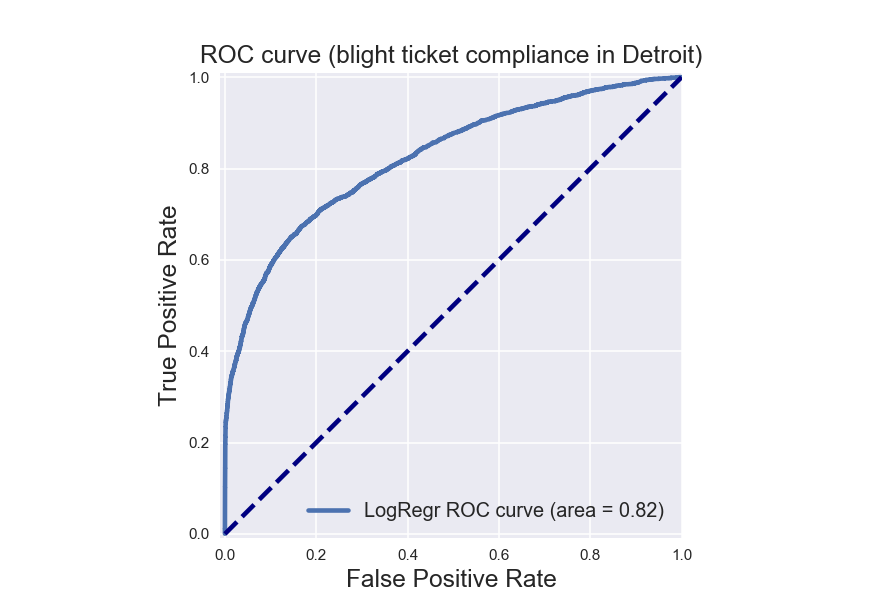

In [51]:
# 5. Plot the ROC for the y_test that was splitted from the training data train.csv file.

# calculate the needed information in order to get the AUC_score
y_pred_grd = grd.predict_proba(X_2_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
roc_auc_grd = auc(fpr_grd, tpr_grd)

################################################# plot the ROC for the y_test #####################

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_grd, tpr_grd, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_grd))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (blight ticket compliance in Detroit)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
# The dotted line here is the classifier curve that secretly results from a classifier
# that randomly guesses the label for a binary class. 
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()


the AUC_score is 0.82 for the training data, so it seems that this classifier has the potential to get to our goal, it's time to engage the second phase, checking the classifier on the test data.

## PART II: Run the classifier on the provided test file and calculate the 'AUC_score'

The original test file that was provided by the course from the Michigan University didn't provided the label space for the test.csv file, since the requirement of the project was for the model to give a prediction of the label space. However, I would like to be able to compare it to the real label space and create the ROC curve, so I have used the information from Detroit City's website.

In [54]:
# 1. Read the test file, organize the test file and merge it with the Blight_Violations file in order to get the label feature.

# read the test data of blight ticket compliance in Detroit into a dataframe 
test_df = pd.read_csv('test.csv', header=0, sep=',', encoding='cp1252',  
                 dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str, 'violator_name':str, 'mailing_address_str_number': str})
# since: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
#  interactivity=interactivity, compiler=compiler, result=result)
# we have to specify the type, i.e  dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str}
# encoding='latin1', encoding='iso-8859-1' or encoding='cp1252'; encoding = utf-8 these the various encodings found on Windows.

# handling the unwanted characters: remove '>' in 'mailing_address_str_name'
test_df['mailing_address_str_name'] = test_df['mailing_address_str_name'].str.replace(r"\>"," ")
test_df['violator_name'] = test_df['violator_name'].str.replace(r"\>"," ")

# let's see the data
# test_df.head()

# read the Detroit Blight-Violations Records into a dataframe 
# taken from the website: https://data.detroitmi.gov/Property-Parcels/Blight-Violations/ti6p-wcg4
Blight_df = pd.read_csv('Blight_Violations.csv', header=0, sep=',', encoding='cp1252',  
                 dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str, 'violator_name':str, 
                        'mailing_address_str_number': str, 'Violation Zip Code': str,
                       'Violation Date': str, 'Ticket Issued Time': str})
# since: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
#  interactivity=interactivity, compiler=compiler, result=result)
# we have to specify the type, i.e  dtype={'zip_code': str, 'non_us_str_code': str, 'grafitti_status': str}
# encoding='latin1', encoding='iso-8859-1' or encoding='cp1252'; encoding = utf-8 these the various encodings found on Windows.

# let's see the data
# df.head(20)

# merge the two df in order to get the label column for the test file
test_df_compliance = pd.merge(test_df, Blight_df, how='inner', left_on = 'ticket_id', right_on = 'Ticket ID')

# Missing values is taken as float, whereas others are str. replace the NaN to ''
test_df_compliance['Payment Status'] = test_df_compliance['Payment Status'].fillna('')

# change the name of the column of the y_test - the label column
test_df_compliance.rename(columns={'Payment Status': 'payment_status'}, inplace=True)
# make a binary dictionary to label correctly the label column for the roc_curve to accept
dict = {'': 0.0, 'NO PAYMENT DUE': 1.0, 'PAID IN FULL': 1.0, 'PARTIAL PAYMENT APPLIED': 0.0}
test_df_compliance.payment_status.replace(dict, inplace=True)

# let's see the data
# test_df_compliance.head()

# Build the feature space and the label space
X_testfile = test_df_compliance.loc[:,'ticket_id':'judgment_amount'] # selects all rows and all columns beginning at 'ticket_id' up to and including 'judgment_amount' 
X_testfile['grafitti_status'] = test_df_compliance['grafitti_status'] # add 'grafitti_status'
y_testfile = test_df_compliance['payment_status'].as_matrix() # create the label space

#y_testfile = pd.DataFrame(data = test_df_compliance['payment_status'], index = test_df_compliance.index) # create the label space

# let's see the data
# X_testfile.head()
y_testfile
# array([ 0.,  0.,  0., ...,  0.,  0.,  0.])


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [30]:
# 2. Engage the classifier on the feature space of the test.csv file.

# can't pass str to the fit() method of GBTC hence encode every labels in the df with value between 0 and n_classes-1  

# Missing values is taken as float, whereas others are str. replace the NaN to ''
X_testfile = X_testfile.fillna('')

# limit to categorical data using DataFrame.select_dtypes()
X_3 = X_testfile.select_dtypes(include=[object])
# X_testfile.head()

# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()


# fit and transform
# use DataFrame.apply() to apply le.fit_transform to all columns
X_4 = X_3.apply(le.fit_transform)
# X_4.head(50)

# add the rest of the data
###float_columns = ['ticket_id', 'violation_street_number', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee',
###                 'discount_amount', 'clean_up_cost', 'judgment_amount']

X_4[float_columns] = X_testfile[float_columns]
X_4.head(10)
# 10 rows × 27 columns

# predict the probability that each corresponding ticket from test.csv will be paid, this is the part where the GBDT is engaged
y_testfile_pred_grd = grd.predict_proba(X_4)[:, 1]
# y_testfile_pred_grd
# array([ 0.54017691,  0.41656027,  0.54975157, ...,  0.80806118,
#         0.79647891,  0.98836275])

,agency_name,inspector_name,violator_name,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,...,grafitti_status,ticket_id,violation_street_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount
0,1,45,12409,1181,0,1130,11751,740,24,1317,...,0,284932,10041.0,200.0,20.0,10.0,20.0,0.0,0.0,250.0
1,1,65,36292,471,0,3478,5503,740,24,1331,...,0,285362,18520.0,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0
2,1,65,36292,471,0,3478,5503,740,24,1331,...,0,285361,18520.0,100.0,20.0,10.0,10.0,0.0,0.0,140.0
3,1,99,15026,255,0,4325,9233,3041,24,1256,...,0,285338,1835.0,200.0,20.0,10.0,20.0,0.0,0.0,250.0
4,1,99,7991,255,0,5941,8518,1559,24,1233,...,0,285346,1700.0,100.0,20.0,10.0,10.0,0.0,0.0,140.0
5,1,99,7991,255,0,5941,8518,1559,24,1233,...,0,285345,1700.0,200.0,20.0,10.0,20.0,0.0,0.0,250.0
6,1,99,7991,255,0,5941,8518,1559,24,1233,...,0,285347,1700.0,50.0,20.0,10.0,5.0,0.0,0.0,85.0
7,1,99,25952,836,0,1049,15647,2286,24,1414,...,0,285342,1605.0,200.0,20.0,10.0,0.0,0.0,0.0,230.0
8,1,14,17288,120,0,5907,6002,1085,46,536,...,0,285530,3408.0,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0
9,1,14,37414,1211,0,6727,4648,1027,6,2708,...,0,284989,8040.0,500.0,20.0,10.0,50.0,0.0,0.0,580.0


<IPython.core.display.Javascript object>


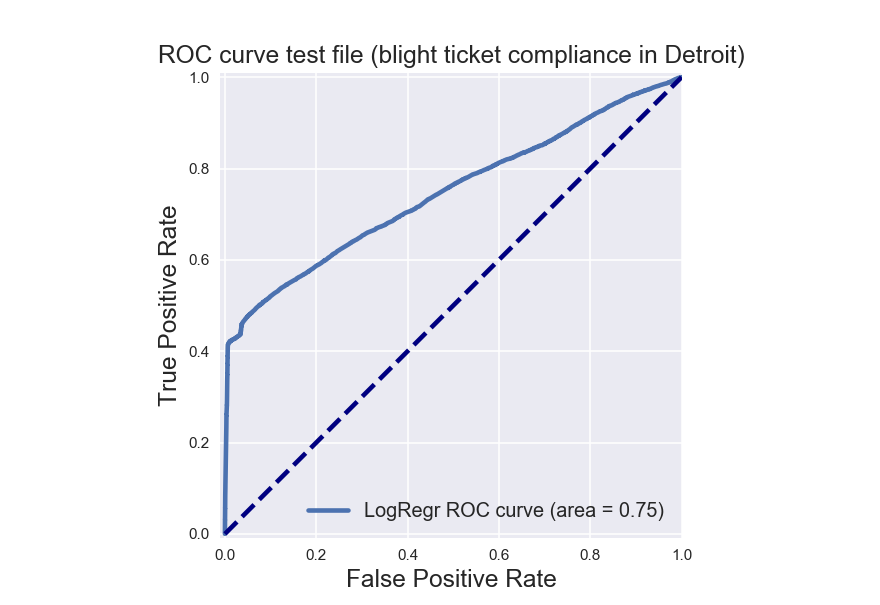

In [55]:
# 3. Plot the ROC for the y_test that was gathered from the test.csv file.

# calculate the needed information in order to get the AUC_score
# y_testfile_pred_grd = grd.predict_proba(X_4)[:, 1] # already been calculated
fpr_grd, tpr_grd, _ = roc_curve(y_testfile, y_testfile_pred_grd)
roc_auc_grd = auc(fpr_grd, tpr_grd)

################################################# plot the ROC for the y_test #####################

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_grd, tpr_grd, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_grd))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve test file (blight ticket compliance in Detroit)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
# The dotted line here is the classifier curve that secretly results from a classifier
# that randomly guesses the label for a binary class. 
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

As seen in the graph, the classifier completed the task with AUC_score > 0.7

In [56]:
# 4. returns a series of length 61001 with the data being the probability that each corresponding ticket from test.csv 
# will be paid, and the index being the ticket_id.

# concatenate the index and the probability to a series
bm = pd.Series(testfile_pred_grd, index = test_df.ticket_id)
bm 
# ticket_id
# 284932    0.540177
# 285362    0.416560
# 285361    0.549752
# 285338    0.587751
#    ...
# 376500    0.796479
# 369851    0.988363
# Length: 61001, dtype: float64 



ticket_id
284932    0.540177
285362    0.416560
285361    0.549752
285338    0.587751
285346    0.615268
285345    0.568921
285347    0.578602
285342    0.548722
285530    0.520008
284989    0.486356
285344    0.529923
285343    0.564625
285340    0.540213
285341    0.528147
285349    0.571862
285348    0.529344
284991    0.490191
285532    0.489664
285406    0.463789
285001    0.506116
285006    0.437458
285405    0.387709
285337    0.481882
285496    0.569761
285497    0.598197
285378    0.504084
285589    0.460954
285585    0.501097
285501    0.590844
285581    0.391965
            ...   
376367    0.700989
376366    0.749756
376362    0.758592
376363    0.775713
376365    0.700989
376364    0.749756
376228    0.791532
376265    0.742171
376286    0.987794
376320    0.775398
376314    0.749756
376327    0.989599
376385    0.989826
376435    0.990413
376370    0.990720
376434    0.871426
376459    0.828242
376478    0.643040
376473    0.755456
376484    0.726939
376482    0.648080
37

In [49]:
# given test script to test the outcome by size, type etc.


res = 'Data type Test: '
res += ['Failed: type(bm) should Series\n','Passed\n'][type(bm)==pd.Series]
res += 'Data shape Test: '
res += ['Failed: len(bm) should be 61001\n','Passed\n'][len(bm)==61001]
res += 'Data Values Test: '
res += ['Failed: all values should be in [0.,1.]\n','Passed\n'][all((bm<=1.) & (bm>=0.))]
res += 'Data Values type Test: '
res += ['Failed: bm.dtype should be float\n','Passed\n'][str(bm.dtype).count('float')>0]
res += 'Index type Test: '
res += ['Failed: type(bm.index) should be Int64Index\n','Passed\n'][type(bm.index)==pd.Int64Index]
res += 'Index values type Test: '
res += ['Failed: type(bm.index[0]) should be int64\n','Passed\n'][str(type(bm.index[0])).count("int64")>0]

res += 'Output index shape test:'
res += ['Failed, bm.index.shape should be (61001,)\n','Passed\n'][bm.index.shape==(61001,)]

res += 'Output index test: '
if bm.index.shape==(61001,):
    res +=['Failed\n','Passed\n'][all(pd.read_csv('test.csv',usecols=[0],index_col=0).sort_index().index.values==bm.sort_index().index.values)]
else:
    res+='Failed'
print(res)

Data type Test: Passed
Data shape Test: Passed
Data Values Test: Passed
Data Values type Test: Passed
Index type Test: Passed
Index values type Test: Passed
Output index shape test:Passed
Output index test: Passed

